## Run model and collect predictions on BABILong

In [ ]:
import os
os.chdir('..')

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import datasets
from tqdm.auto import tqdm
import pandas as pd
import time
import json

from pathlib import Path

from babilong.prompts import DEFAULT_PROMPTS, DEFAULT_TEMPLATE, get_formatted_input
from babilong.babilong_utils import compare_answers

In [3]:
model_name = 'lmsys/longchat-7b-v1.5-32k'
dtype = torch.bfloat16
device = 'cuda:0'
max_length = 34000

In [4]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True,
                                             device_map=device, torch_dtype=dtype,
                                             attn_implementation='flash_attention_2')
model = model.eval()

/home/jovyan/envs/py3.11_pt2_cu11.8/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/jovyan/envs/py3.11_pt2_cu11.8/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/jovyan/envs/py3.11_pt2_cu11.8/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/home/jovyan/envs/py3.11_pt2_cu11.8/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- t

In [5]:
generate_kwargs = {
    'num_beams': 1,
    'do_sample': False,
    'temperature': None,
    'top_p': None,
    'top_k': None,
}

In [6]:
tasks = ['qa1', 'qa2','qa3', 'qa4', 'qa5'] #, 'qa6', 'qa7', 'qa8', 'qa9', 'qa10']
split_names = ['0k', '1k', '2k', '4k', '8k', '16k', '32k'] # ['1k', '2k', '4k', '8k', '16k', '32k', '64k', '128k']

In [ ]:
for task in tqdm(tasks, desc='tasks'):
    prompt_cfg = {
        'instruction': '', # DEFAULT_PROMPTS[task]['instruction'],
        'examples': '', # DEFAULT_PROMPTS[task]['examples'],
        'post_prompt': '',
        'template': DEFAULT_TEMPLATE,
    }
    prompt_name = [f'{k}_no' if len(prompt_cfg[k]) == 0 else f'{k}_yes' for k in prompt_cfg if k != 'template']
    prompt_name = '_'.join(prompt_name)
    for split_name in tqdm(split_names, desc='lengths'):
        data = datasets.load_dataset("booydar/babilong", split_name)
        task_data = data[task].select(range(100))

        outfile = Path(f'./babilong_evals/{model_name}/{task}_{split_name}_{prompt_name}.csv')
        outfile.parent.mkdir(parents=True, exist_ok=True)
        cfg_file = f'./babilong_evals/{model_name}/{task}_{split_name}_{prompt_name}.json'
        json.dump({'prompt': prompt_cfg, 'generate_kwargs': generate_kwargs}, open(cfg_file, 'w'), indent=4)

        df = pd.DataFrame({'target': [], 'output': []})

        for sample in tqdm(task_data):
            target = sample['target']
            context = sample['input']
            question = sample['question']

            input_text = get_formatted_input(context, question, prompt_cfg['examples'],
                                             prompt_cfg['instruction'], prompt_cfg['post_prompt'],
                                             template=DEFAULT_TEMPLATE)

            input = tokenizer(input_text, return_tensors="pt", add_special_tokens=True).to(model.device)
            sample_length = input['input_ids'].shape[1]
            with torch.no_grad():
                output = model.generate(**input, max_length=sample_length+25, **generate_kwargs)
            output = output[0][input['input_ids'].shape[1]:]
            output = tokenizer.decode(output, skip_special_tokens=True).strip()

            df.loc[len(df)] = [target, output]
            df.to_csv(outfile)

## Evaluate result

In [7]:
import seaborn as sns
import matplotlib
import matplotlib.pylab as plt
from matplotlib.colors import LinearSegmentedColormap

import pandas as pd
import numpy as np

# import os
# os.chdir('..')

In [8]:
results_folder = './babilong_evals'
model_name = 'lmsys/longchat-7b-v1.5-32k'
prompt_name = 'instruction_no_examples_no_post_prompt_no'

In [9]:
tasks = ['qa1', 'qa2', 'qa3', 'qa4', 'qa5']#, 'qa6', 'qa7', 'qa8', 'qa9', 'qa10']
lengths = ['0k', '1k', '2k', '4k', '8k', '16k', '32k']

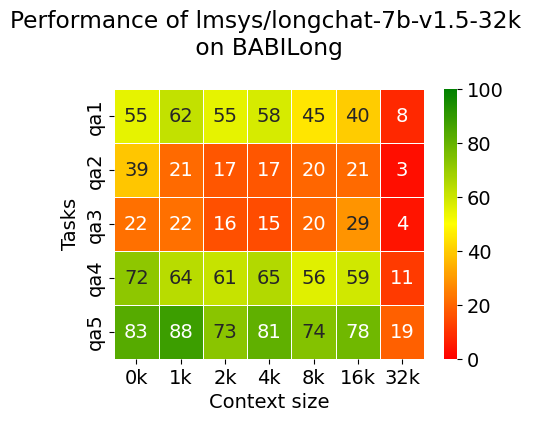

In [10]:
accuracy = np.zeros((len(tasks), len(lengths)))
for j, task in enumerate(tasks):
    for i, ctx_length in enumerate(lengths):
        fname = f'./{results_folder}/{model_name}/{task}_{ctx_length}_{prompt_name}.csv'
        if not os.path.isfile(fname):
            print(f'No such file: {fname}')
            continue
        
        df = pd.read_csv(fname)
        
        if df['output'].dtype != object:
            df['output'] = df['output'].astype(str)
        df['output'] = df['output'].fillna('')


        df['correct'] = df.apply(lambda row: compare_answers(row['target'], row['output']), axis=1)
        score = df['correct'].sum()
        accuracy[j, i] = 100 * score / len(df) if len(df) > 0 else 0

# Set large font sizes for better visibility in the PDF
matplotlib.rc('font', size=14)

# Create a colormap for the heatmap
cmap = LinearSegmentedColormap.from_list('ryg', ["red", "yellow", "green"], N=256)

# Create the heatmap
fig, ax = plt.subplots(figsize=(5, 3.5))  # Adjust the size as necessary
sns.heatmap(accuracy, cmap=cmap, vmin=0, vmax=100, annot=True, fmt=".0f",
            linewidths=.5, xticklabels=lengths, yticklabels=tasks, ax=ax)
ax.set_title(f'Performance of {model_name} \n on BABILong \n')
ax.set_xlabel('Context size')
ax.set_ylabel('Tasks')

# Save the figure to a PDF
# plt.savefig('all_tasks_performance.pdf', bbox_inches='tight')
plt.show()